In [1]:
#! pip install progressbar

In [2]:
from progressbar import ProgressBar

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
#from sklearn.neighbors import kneighbors_graph, NearestNeighbors
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [4]:
def StockVol(histoPrice):
    """
    Compute the stock volatility under GBM using 1-year historical prices
    
    Inputs:
        histoPrice: an array of daily historical prices for one year
        
    Returns:
        histoVol: annualized historical volatility
    """
    
    logret = np.diff(np.log(histoPrice))
    sigma = np.sqrt(np.var(logret))
    histoVol = sigma*np.sqrt(252)  # annualize volatility
    
    return histoVol

In [5]:
def StockPath(n,sigma=0.2,S0=100,T=1,nump=252,r=0.01,delta = 0):
    """
    Generate n stock paths
    
    Inputs:
        n: number of paths generated
        sigma: volatility of the stock
        S0: current stock price
        T: terminal time in yearly unit
        nump: number of time periods
        r: interest rate
        delta: continuous dividend yield of the stock
        
    Returns:
        S: an array of stock paths
    """
    
    X = np.zeros((n,1+nump))
    X[:,0] = S0
    for i in range(len(X)):
        Z = np.random.normal(0, 1, nump)
        X[i,1:]=np.exp(sigma*np.sqrt(T/nump)*Z+(r-delta-sigma**2/2)*(T/nump))
    
    S = []   
    for i in range (n):
        S.append(np.cumprod(X[i,:]))
    
    return np.array(S)

In [6]:
def EurOptPrice(paths,K,r=0.01,T=1):
    """
    generate the European put option price through Monte Carlo method
    
    Inputs:
        paths: an array of stock paths
        K: strike price
        r: interest rate
        T: terminal time
        
    Returns:
        Payoff: discounted payoffs
        price: estimated price of the European put option
        variance: variance of discounted payoffs
        
    """
    
    Payoff = np.maximum(K-paths[:,-1],0)*np.exp(-r*T)
    price = np.mean(Payoff)
    variance = np.var(Payoff)
    
    return (Payoff,price,variance)
    

In [7]:
def AmeOptPrice(paths,K,r=0.01,T=1,nump = 252):
    """
    generate the American put option price without control variable
    
    Inputs:
        paths: an array of stock paths
        K: strike price
        r: interest rate
        T: terminal time
        nump: number of periods
        
    Returns:
        Payoff: discounted payoffs
        price: estimated price of the European put option
        variance: variance of discounted payoffs
        
    """
    deltaT = T/nump
    P = np.maximum(K-paths,0)
    H = np.zeros(paths.shape)
    V = np.zeros(paths.shape)
    
    H[:,-1] = P[:,-1]
    V[:,-1] = P[:,-1]
    
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)  #Define Random Forest Regressor 
    pbar = ProgressBar()
    for i in pbar(range(1,len(H[0])-1)):
        X = paths[:,-i-1].reshape(-1,1)
        Y = V[:,-i].reshape(-1,1)

        reg = rf.fit(X, Y.ravel())  # Polynomial regression (degree = 5)
        H[:,-i-1] = rf.predict(X)*np.exp(-r*deltaT)   # discounted holding value
        V[:,-i-1] = np.maximum(P[:,-i-1], H[:,-i-1])
 
    reg = rf.fit(X, Y.ravel())
    H[:,0] = rf.predict(X)*np.exp(-r*deltaT)   # discounted holding value
    V[:,0] = np.maximum(P[:,0], H[:,0])  # discounted payoffs at t = 0
    
    Payoff = V[:,0]
    price = np.mean(Payoff)
    variance = np.var(Payoff)
    
    return(Payoff, price, variance)    

Test

In [8]:
S = StockPath(1000,0.2,100,1,252,0.01,delta = 0)

In [9]:
Payoff,price,variance = EurOptPrice(S,95,0.01,1)

In [10]:
Payoff

array([1.41908293e+01, 0.00000000e+00, 2.90693472e+01, 0.00000000e+00,
       1.26965314e+01, 0.00000000e+00, 0.00000000e+00, 1.00028369e+01,
       0.00000000e+00, 8.12757144e+00, 1.35890877e+01, 0.00000000e+00,
       0.00000000e+00, 2.38922831e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.77517165e+01, 6.19727507e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.81186284e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.27068394e+01, 0.00000000e+00, 0.00000000e+00,
       1.00320561e+01, 1.28868039e+01, 0.00000000e+00, 0.00000000e+00,
       2.75521535e+00, 0.00000000e+00, 1.17466411e+00, 1.88262606e+00,
       0.00000000e+00, 7.48525941e+00, 0.00000000e+00, 3.37497155e+01,
       0.00000000e+00, 0.00000000e+00, 3.63039450e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.09937595e+00, 0.00000000e+00,
      

In [11]:
price

5.3452891145383

In [12]:
variance

71.47857394470518

In [13]:
Payoff1,price1,variance1 = AmeOptPrice(paths=S,K=95,r=0.01,T=1,nump = 252)

100% |########################################################################|


In [14]:
Payoff1

array([5.5442126 , 5.88975714, 6.25612464, 5.78437881, 5.72385937,
       5.53032088, 7.21002797, 6.90693482, 5.00954825, 5.69500657,
       4.96846942, 5.34987796, 6.70809443, 6.19046041, 6.59512099,
       4.81078652, 5.62693626, 7.60175933, 6.48120445, 5.38767309,
       6.96591094, 5.77018189, 5.23023959, 5.15185715, 7.34634802,
       4.60282706, 5.93996772, 6.7059081 , 6.39959041, 6.18103752,
       5.52546891, 5.69595335, 5.66252021, 6.82263755, 5.53487363,
       5.89961485, 6.2818218 , 6.2595821 , 6.17097766, 5.4997932 ,
       5.16006903, 6.96299217, 5.83287175, 5.14096314, 6.1206845 ,
       6.73885851, 5.8630096 , 5.40264392, 5.48785984, 5.23585418,
       5.09440729, 5.09348651, 5.43175965, 6.09137222, 6.07707416,
       5.99650936, 5.80432695, 7.0364507 , 6.22289956, 6.07155275,
       6.09989571, 5.78843806, 6.41557825, 5.48252243, 6.21870851,
       5.12134493, 5.14959444, 8.06460536, 6.71200839, 5.62360463,
       5.36767055, 5.93757963, 5.44210165, 4.63388087, 6.80599

In [15]:
price1

5.953877143733262

In [16]:
variance1

0.5317370518510958

The followings are just some attempts

C:\Users\zlxxx\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


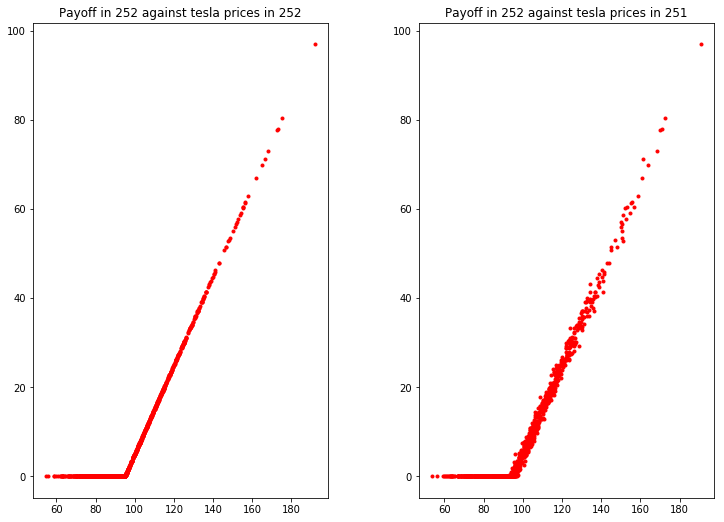

In [189]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
plt.tight_layout(pad=0.4, w_pad=6, h_pad=1.0)

ax1.plot(S[:,-1], Y , 'r.')
ax2.plot(S[:,-2], Y , 'r.')

ax1.set_title('Payoff in 252 against tesla prices in 252')
ax2.set_title('Payoff in 252 against tesla prices in 251')

f.show()

In [187]:
#Define Random Forest Regressor 
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
# Polynomial regression (degree = 5) 
reg1 = rf.fit(X, Y.ravel())
expected_Y_rf = rf.predict(X)

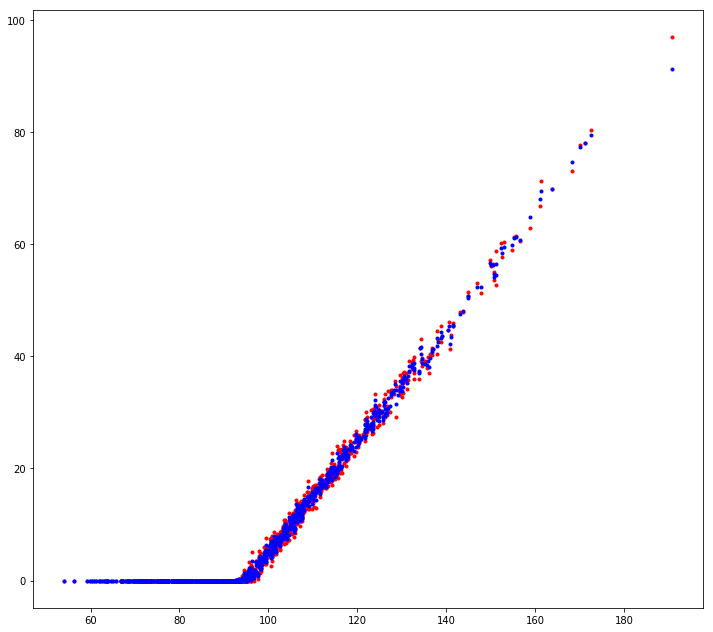

In [188]:
plt.figure(figsize=[12, 11])
plt.plot(X, Y , 'r.')
plt.plot(X, expected_Y_rf, 'b.')